# Second step in pipeline

In [4]:
import random
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

## Implement TopicTiling Algorithm (Riedl, Biemann, 2012)

In [5]:
# Functions for segmentation. Last function calls all of the above. 

def find_window(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = [] 

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.topic_probs[p-window_size:p]
        w_r = dataframe.topic_probs[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas
    minimas, _ = find_peaks(window_cosines_neg, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (neg cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    for i in range(p-1, 0, -1):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    for i in range(p+1, len(cos_sims)):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    sns.lineplot(cosine_similarities_for_windows, ax=axs[0])
    axs[0].set_xlabel("p")
    axs[0].set_ylabel("Cosine similarity")
    if boundaries != None:
        for seg_bound in boundaries:
            axs[0].axvline(seg_bound-window_size, color='r')

    neg_cosines_of_windows= cosine_similarities_for_windows*-1
    sns.lineplot(neg_cosines_of_windows, ax=axs[1])
    axs[1].set_xlabel("p")
    axs[1].set_ylabel("Negative cosine similarity")

    fig.suptitle(f"Cos. Sim. Over Transcript Windows with Segments Marked in Red [window size: {window_size}]")
    plt.show()


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    window_cosines = find_window(dataframe, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds

### Pipeline step 2

In [6]:
# load sentence probabilities from 1 step
sent_proba = np.load('new_testing_proba.npy')

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": list(sent_proba)})
pipeline_df.head(2)

,sentence_no,topic_probs
0,0,"[1.4881586613203362e-93, 1.8617052287938397e-9..."
1,1,"[1.8190957555979366e-97, 1.688008276069578e-97..."


Window size: 2, segments: 49


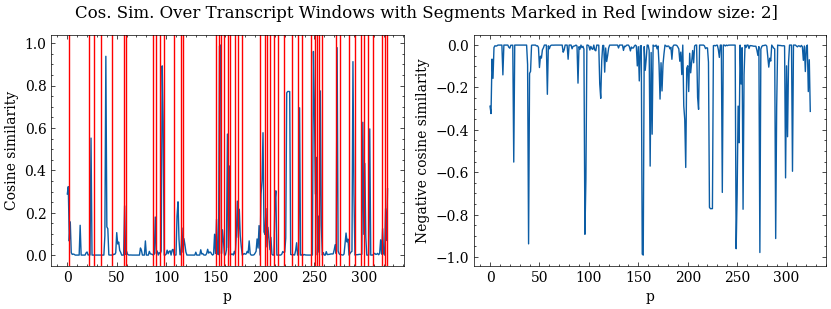

Window size: 7, segments: 43


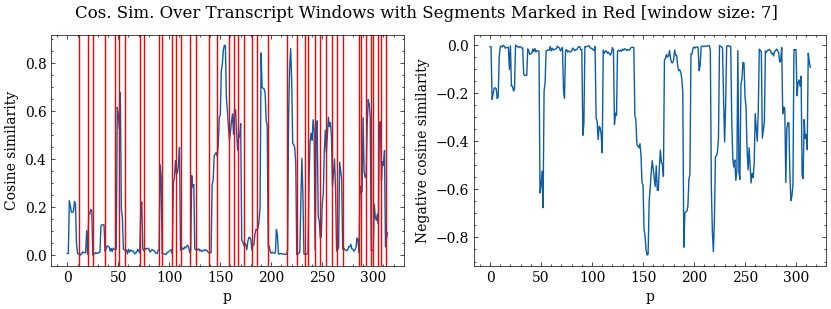

Window size: 12, segments: 50


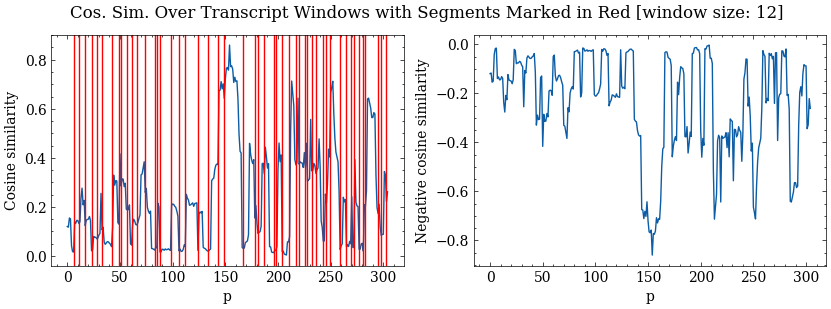

Window size: 17, segments: 36


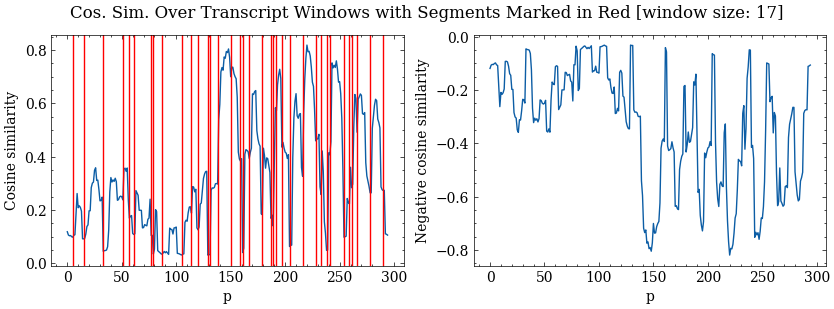

Window size: 22, segments: 43


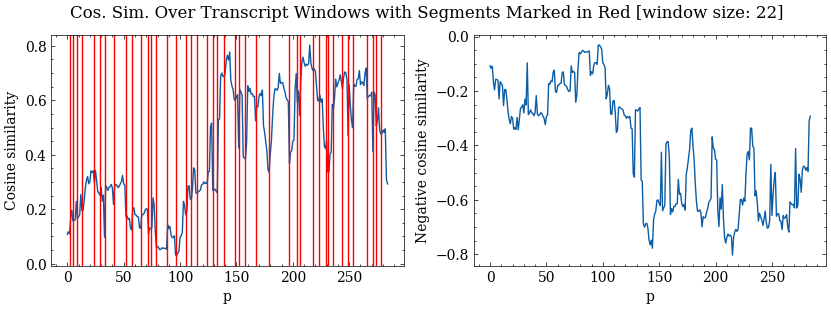

Window size: 27, segments: 45


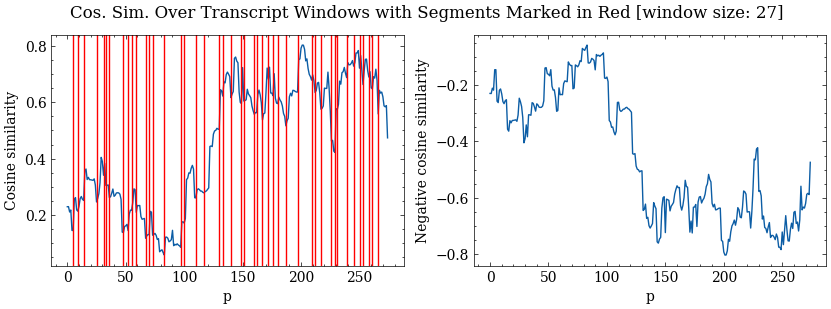

Window size: 32, segments: 40


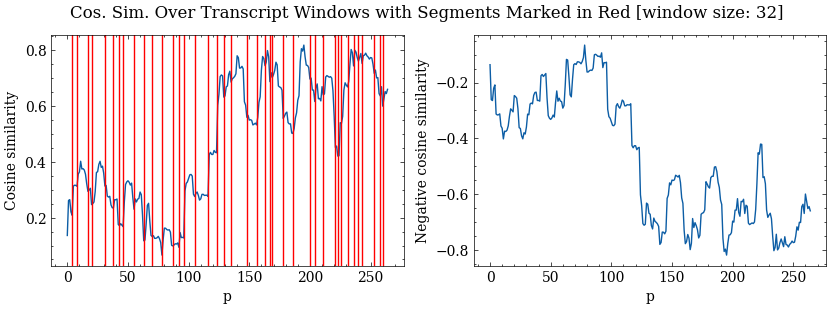

In [7]:
# Plot and analyse with different size windows
windows = [i for i in range(2, 35, 5)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.995)
    cos_sims = find_window(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

## Testing with synthetic data

### Generate synthetic data

In [2]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


### Testing

In [4]:
segmentation_main_call(testing_df)

Candidate boundary at sent. 10, p:7, value (neg cos sim): 0.29475370630691905
Candidate boundary at sent. 20, p:17, value (neg cos sim): 0.3308017982152971
Candidate boundary at sent. 30, p:27, value (neg cos sim): 0.440418494251154
Candidate boundary at sent. 40, p:37, value (neg cos sim): 0.858004506612447
Boundary at sentence 10, p:7, depth score: 0.7050263735328062
Boundary at sentence 20, p:17, depth score: 0.6690722617363228
Boundary at sentence 30, p:27, depth score: 0.5594351112908027


[10, 20, 30]

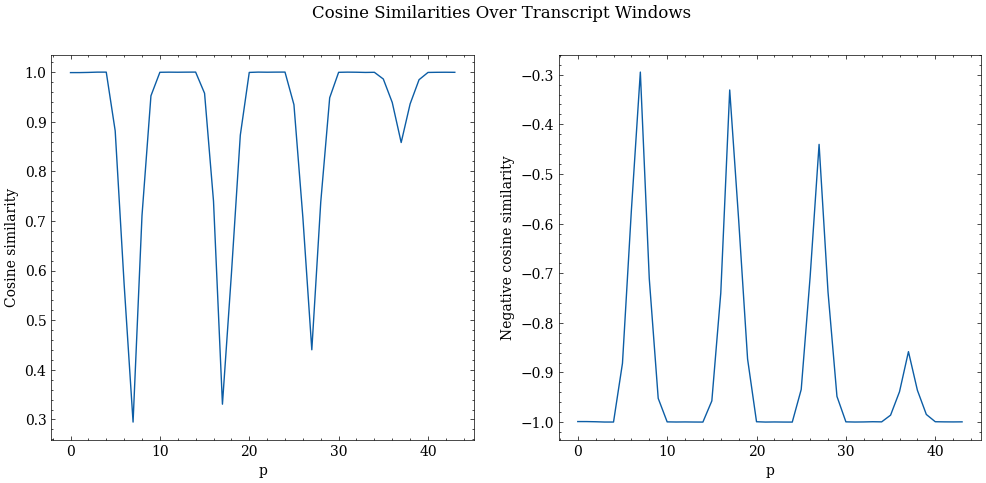

In [5]:
cos_sims = find_window(testing_df)
plot_cosine_scores(cos_sims, window_size=3)

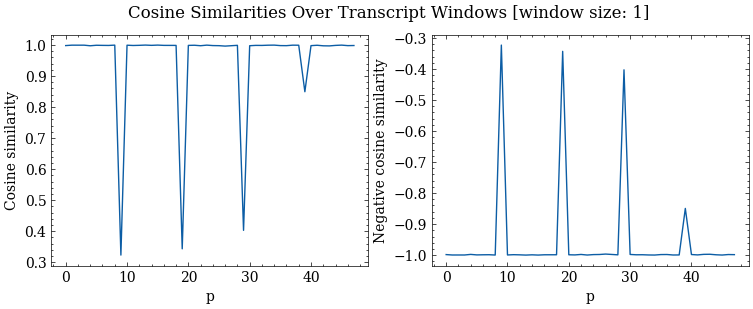

Candidate boundary at sent. 10, p:9, value (neg cos sim): 0.3232
Candidate boundary at sent. 20, p:19, value (neg cos sim): 0.3433
Candidate boundary at sent. 30, p:29, value (neg cos sim): 0.4029
Candidate boundary at sent. 40, p:39, value (neg cos sim): 0.8494
Boundary at sentence 10, p:9, depth score: 0.6763
Boundary at sentence 20, p:19, depth score: 0.6562
Boundary at sentence 30, p:29, depth score: 0.5960




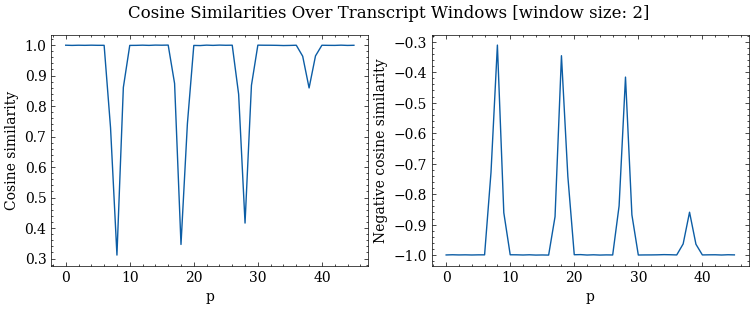

Candidate boundary at sent. 10, p:8, value (neg cos sim): 0.3113
Candidate boundary at sent. 20, p:18, value (neg cos sim): 0.3461
Candidate boundary at sent. 30, p:28, value (neg cos sim): 0.4163
Candidate boundary at sent. 40, p:38, value (neg cos sim): 0.8594
Boundary at sentence 10, p:8, depth score: 0.6884
Boundary at sentence 20, p:18, depth score: 0.6533
Boundary at sentence 30, p:28, depth score: 0.5834




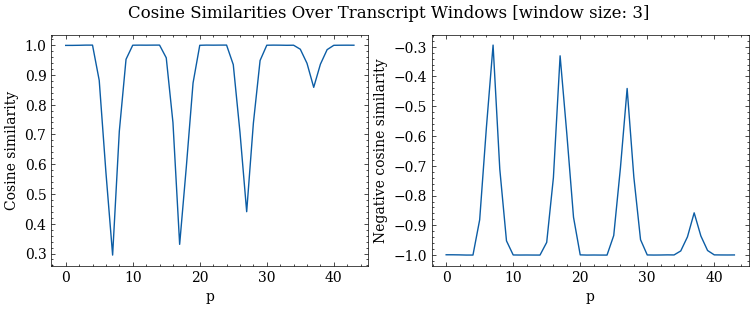

Candidate boundary at sent. 10, p:7, value (neg cos sim): 0.2948
Candidate boundary at sent. 20, p:17, value (neg cos sim): 0.3308
Candidate boundary at sent. 30, p:27, value (neg cos sim): 0.4404
Candidate boundary at sent. 40, p:37, value (neg cos sim): 0.8580
Boundary at sentence 10, p:7, depth score: 0.7050
Boundary at sentence 20, p:17, depth score: 0.6691
Boundary at sentence 30, p:27, depth score: 0.5594




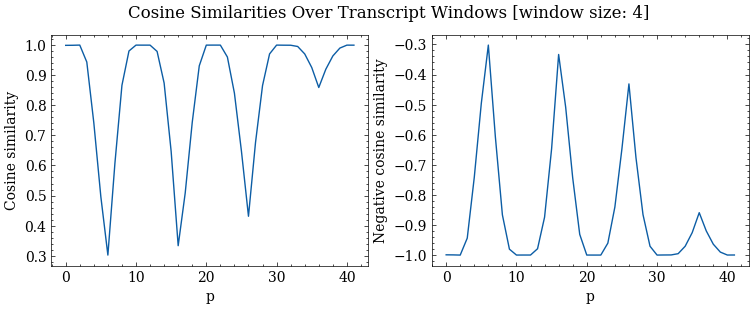

Candidate boundary at sent. 10, p:6, value (neg cos sim): 0.3022
Candidate boundary at sent. 20, p:16, value (neg cos sim): 0.3334
Candidate boundary at sent. 30, p:26, value (neg cos sim): 0.4312
Candidate boundary at sent. 40, p:36, value (neg cos sim): 0.8590
Boundary at sentence 10, p:6, depth score: 0.6977
Boundary at sentence 20, p:16, depth score: 0.6665
Boundary at sentence 30, p:26, depth score: 0.5687




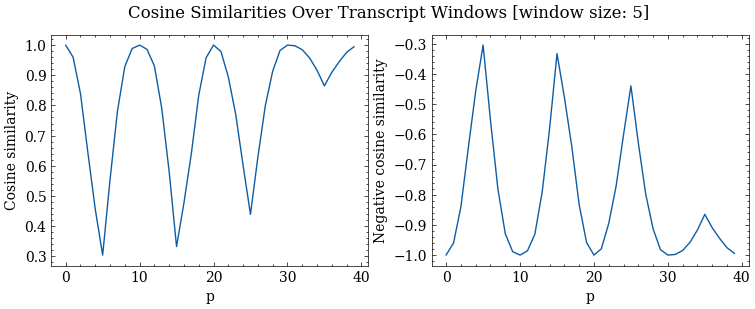

Candidate boundary at sent. 10, p:5, value (neg cos sim): 0.3042
Candidate boundary at sent. 20, p:15, value (neg cos sim): 0.3325
Candidate boundary at sent. 30, p:25, value (neg cos sim): 0.4393
Candidate boundary at sent. 40, p:35, value (neg cos sim): 0.8649
Boundary at sentence 10, p:5, depth score: 0.6756
Boundary at sentence 20, p:15, depth score: 0.6673
Boundary at sentence 30, p:25, depth score: 0.5605




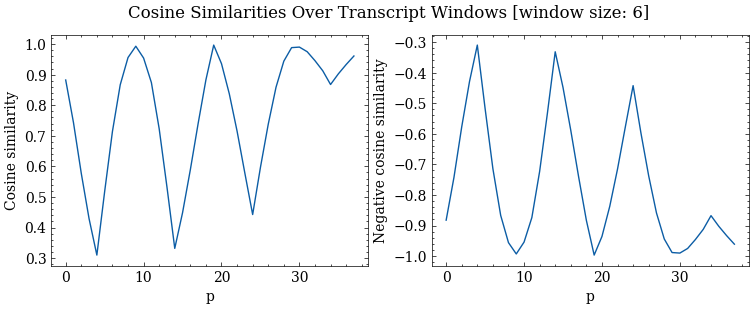

Candidate boundary at sent. 10, p:4, value (neg cos sim): 0.3099
Candidate boundary at sent. 20, p:14, value (neg cos sim): 0.3318
Candidate boundary at sent. 30, p:24, value (neg cos sim): 0.4425
Candidate boundary at sent. 40, p:34, value (neg cos sim): 0.8677
Boundary at sentence 10, p:4, depth score: 0.5579
Boundary at sentence 20, p:14, depth score: 0.6629
Boundary at sentence 30, p:24, depth score: 0.5508




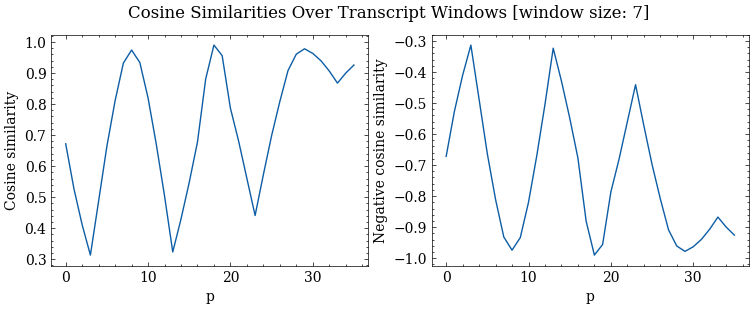

Candidate boundary at sent. 10, p:3, value (neg cos sim): 0.3131
Candidate boundary at sent. 20, p:13, value (neg cos sim): 0.3231
Candidate boundary at sent. 30, p:23, value (neg cos sim): 0.4408
Candidate boundary at sent. 40, p:33, value (neg cos sim): 0.8676
Boundary at sentence 10, p:3, depth score: 0.4375
Boundary at sentence 20, p:13, depth score: 0.6591
Boundary at sentence 30, p:23, depth score: 0.5434




In [13]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(1, 8, 1)]

for window in windows_ls:
    con_sim = find_window(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window)
    segmentation_main_call(testing_df, window_size=window)
    print()
    print()